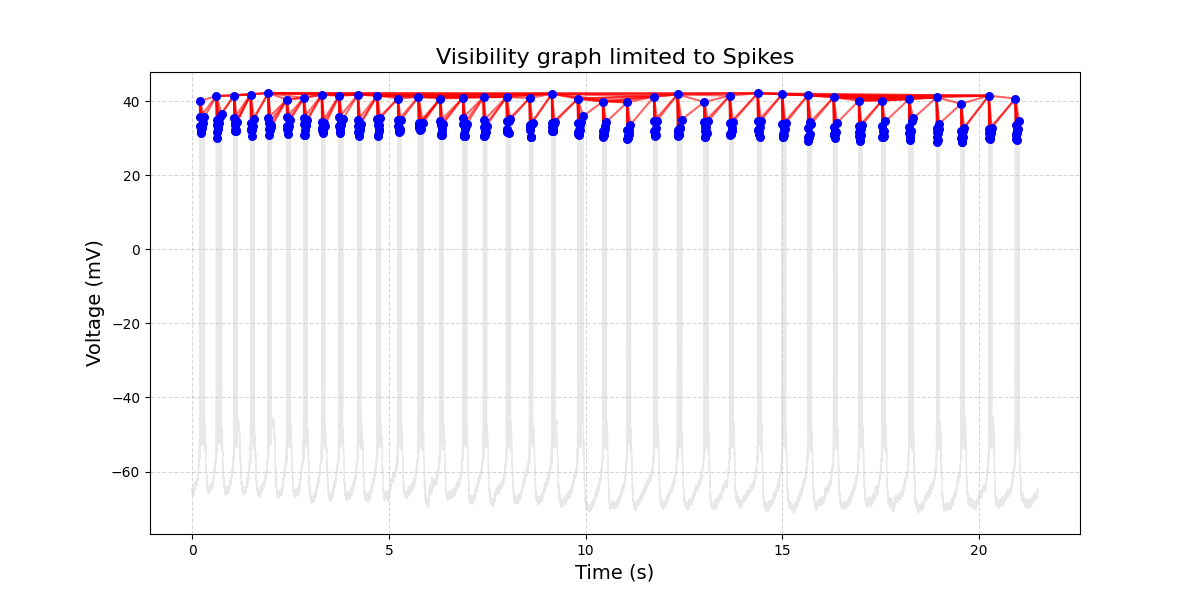

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pyabf
import pandas as pd
from scipy.signal import find_peaks
%matplotlib widget

# Load abf file
abf = pyabf.ABF("bursting/cell89basal.abf")
abf.setSweep(15)
y = abf.sweepY
x = abf.sweepX
fs = abf.dataRate  #Sample frequency

# Detection of spikes
peaks_signal = y

# Detection parameters
thresh_min = -35
thresh_prominence = 15
thresh_min_width = 0.3 * (fs/1000)
distance_min = 1 * (fs/1000)

peaks, peaks_dict = find_peaks(
    peaks_signal,
    height=thresh_min,
    threshold=thresh_min,
    distance=distance_min,
    prominence=thresh_prominence,
    width=thresh_min_width,
    rel_height=0.5
)

# Visibility graph limited to Spikes
plt.figure(figsize=(12,6))
plt.plot(x, y, color='lightgray', linewidth=1, alpha=0.5)  # Background signal

# Only using spikes detected as nodes
x_peaks = x[peaks]
y_peaks = y[peaks]

for a in range(len(y_peaks)):
    for b in range(a+1, len(y_peaks)):
        visible = True
        for c in range(a+1, b):
            y_line = y_peaks[b] + (y_peaks[a]-y_peaks[b])*(x_peaks[b]-x_peaks[c])/(x_peaks[b]-x_peaks[a])
            if y_peaks[c] >= y_line:
                visible = False
                break
        if visible:
            plt.plot([x_peaks[a], x_peaks[b]], [y_peaks[a], y_peaks[b]], 'r-', alpha=0.6)

# Draw nodes of the Spikes
plt.scatter(x_peaks, y_peaks, color='blue', s=30, zorder=5)

# Titles
plt.title("Visibility graph limited to Spikes", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Voltage (mV)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

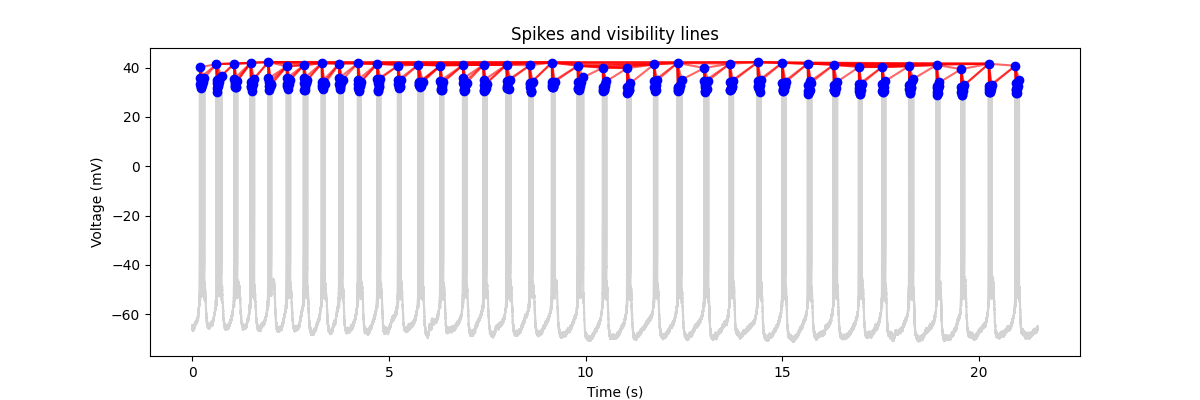

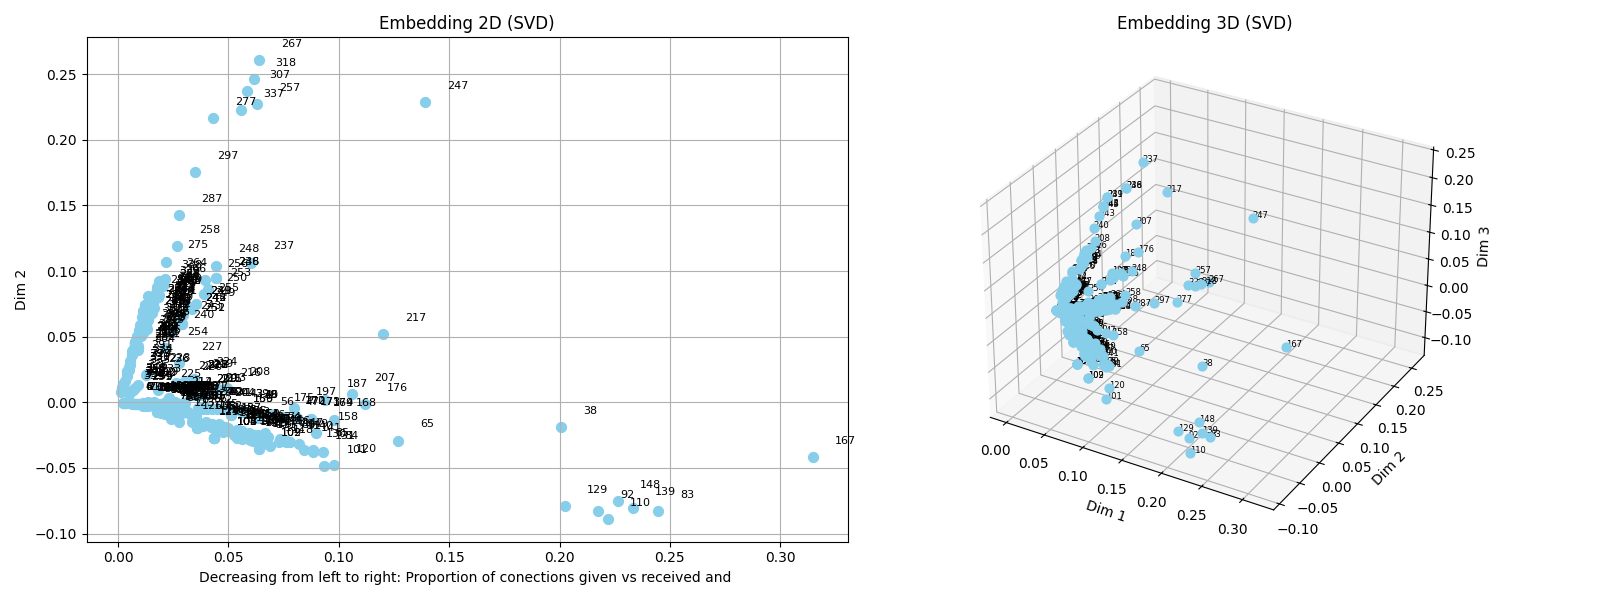

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyabf
import networkx as nx
from numpy.linalg import svd
from scipy.signal import find_peaks
from mpl_toolkits.mplot3d import Axes3D


#Load abf file
abf = pyabf.ABF("bursting/cell89basal.abf")
abf.setSweep(15)
y = abf.sweepY
x = abf.sweepX
fs = abf.dataRate

#Spikes detection
thresh_min = -35
thresh_prominence = 15
thresh_min_width = 0.3 * (fs/1000)
distance_min = 1 * (fs/1000)

peaks, _ = find_peaks(
    y,
    height=thresh_min,
    threshold=thresh_min,
    distance=distance_min,
    prominence=thresh_prominence,
    width=thresh_min_width,
    rel_height=0.5
)

x_peaks = x[peaks]
y_peaks = y[peaks]

#Create visibility graph
G = nx.Graph()
G.add_nodes_from(range(len(y_peaks)))

plt.figure(figsize=(12,4))
plt.plot(x, y, color='lightgray')  #Original signal (as reference)
plt.scatter(x_peaks, y_peaks, color='blue', zorder=5)  # spikes

for a in range(len(y_peaks)):
    for b in range(a+1, len(y_peaks)):
        visible = True
        for c in range(a+1, b):
            y_line = y_peaks[b] + (y_peaks[a]-y_peaks[b])*(x_peaks[b]-x_peaks[c])/(x_peaks[b]-x_peaks[a])
            if y_peaks[c] >= y_line:
                visible = False
                break
        if visible:
            G.add_edge(a, b)  #graph edges
            plt.plot([x_peaks[a], x_peaks[b]], [y_peaks[a], y_peaks[b]], 'r-', alpha=0.6)

plt.title("Spikes and visibility lines")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.show()


#Embeddings with SVD
A = nx.to_numpy_array(G)
U, S, Vt = svd(A)
embeddings_2d = U[:, :2]
embeddings_3d = U[:, :3]

#Embeddings visualization
fig = plt.figure(figsize=(16,6))

# 2D
ax2 = fig.add_subplot(1, 2, 1)
for i, node in enumerate(G.nodes()):
    ax2.scatter(embeddings_2d[i,0], embeddings_2d[i,1], s=50, c="skyblue")
    ax2.text(embeddings_2d[i,0]+0.01, embeddings_2d[i,1]+0.01, str(node), fontsize=8)
ax2.set_title("Embedding 2D (SVD)")
ax2.set_xlabel("Decreasing from left to right: Proportion of conections given vs received and ")
ax2.set_ylabel("Dim 2")
ax2.grid(True)

# 3D
ax3 = fig.add_subplot(1, 2, 2, projection='3d')
for i, node in enumerate(G.nodes()):
    ax3.scatter(embeddings_3d[i,0], embeddings_3d[i,1], embeddings_3d[i,2], s=40, c="skyblue")
    ax3.text(embeddings_3d[i,0], embeddings_3d[i,1], embeddings_3d[i,2], str(node), fontsize=6)
ax3.set_title("Embedding 3D (SVD)")
ax3.set_xlabel("Dim 1")
ax3.set_ylabel("Dim 2")
ax3.set_zlabel("Dim 3")

plt.tight_layout()
plt.show()

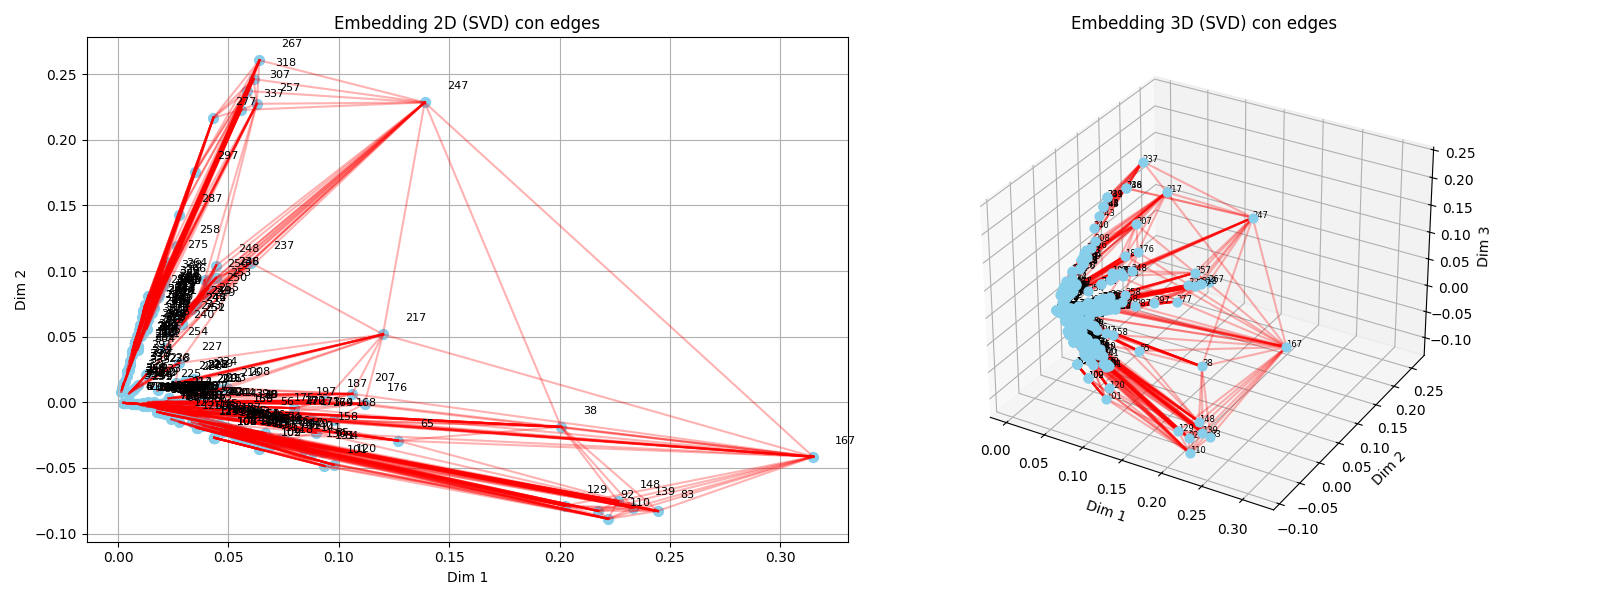

In [3]:
# Embeddings visualization con edges
fig = plt.figure(figsize=(16,6))

# 2D
ax2 = fig.add_subplot(1, 2, 1)
for i, node in enumerate(G.nodes()):
    ax2.scatter(embeddings_2d[i,0], embeddings_2d[i,1], s=50, c="skyblue")
    ax2.text(embeddings_2d[i,0]+0.01, embeddings_2d[i,1]+0.01, str(node), fontsize=8)

# Dibujar edges en 2D
for u, v in G.edges():
    x_vals = [embeddings_2d[u,0], embeddings_2d[v,0]]
    y_vals = [embeddings_2d[u,1], embeddings_2d[v,1]]
    ax2.plot(x_vals, y_vals, 'r-', alpha=0.3)  # líneas finas entre nodos conectados

ax2.set_title("Embedding 2D (SVD) con edges")
ax2.set_xlabel("Dim 1")
ax2.set_ylabel("Dim 2")
ax2.grid(True)


# 3D
ax3 = fig.add_subplot(1, 2, 2, projection='3d')
for i, node in enumerate(G.nodes()):
    ax3.scatter(embeddings_3d[i,0], embeddings_3d[i,1], embeddings_3d[i,2], s=40, c="skyblue")
    ax3.text(embeddings_3d[i,0], embeddings_3d[i,1], embeddings_3d[i,2], str(node), fontsize=6)

# Dibujar edges en 3D
for u, v in G.edges():
    x_vals = [embeddings_3d[u,0], embeddings_3d[v,0]]
    y_vals = [embeddings_3d[u,1], embeddings_3d[v,1]]
    z_vals = [embeddings_3d[u,2], embeddings_3d[v,2]]
    ax3.plot(x_vals, y_vals, z_vals, 'r-', alpha=0.3)

ax3.set_title("Embedding 3D (SVD) con edges")
ax3.set_xlabel("Dim 1")
ax3.set_ylabel("Dim 2")
ax3.set_zlabel("Dim 3")

plt.tight_layout()
plt.show()